<a href="https://colab.research.google.com/github/KennethV322/unsupervised-predict-streamlit-template/blob/master/Movie_recV11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud, STOPWORDS
import re
import string
import nltk
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy.
import matplotlib.pyplot as plt
import seaborn as sns
# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [5]:
pip install scikit-surprise

  Using cached scikit-surprise-1.1.3.tar.gz (771 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162731 sha256=744a1c9fe1afaf5f721c5e04613323e2a909eabe5c189ec3285c279e736312ce
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [11]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_imdb_data = pd.read_csv('imdb_data.csv')
df_movies = pd.read_csv('movies.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

ParserError: Error tokenizing data. C error: Expected 4 fields in line 40125, saw 6


In [66]:
df_train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1.518350e+09
1,106343,5,4.5,1.206239e+09
2,146790,5459,5.0,1.076216e+09
3,106362,32296,2.0,1.423043e+09
4,9041,366,3.0,8.333758e+08


In [67]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240787 entries, 0 to 240786
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     240787 non-null  int64  
 1   movieId    240787 non-null  int64  
 2   rating     240786 non-null  float64
 3   timestamp  240786 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 7.3 MB


In [68]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599399 entries, 0 to 599398
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   599399 non-null  int64  
 1   movieId  599398 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 9.1 MB


In [69]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [70]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [71]:
df_imdb_data.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [72]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [73]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [74]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [75]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186071 entries, 0 to 186070
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     186071 non-null  int64 
 1   movieId    186071 non-null  int64 
 2   tag        186071 non-null  object
 3   timestamp  186071 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.7+ MB


In [76]:
df_test.head()

,userId,movieId
0,1,2011.0
1,1,4144.0
2,1,5767.0
3,1,6711.0
4,1,7318.0


In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599399 entries, 0 to 599398
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   599399 non-null  int64  
 1   movieId  599398 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 9.1 MB


In [78]:
df_genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [79]:
df_genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [80]:
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [81]:
print (f'Number of ratings in dataset: {df_train.shape[0]}')

Number of ratings in dataset: 240787


In [82]:
print (f'Number of users in dataset: {df_test.shape[0]}')

Number of users in dataset: 599399


Average rating in dataset: 3.535215917868979


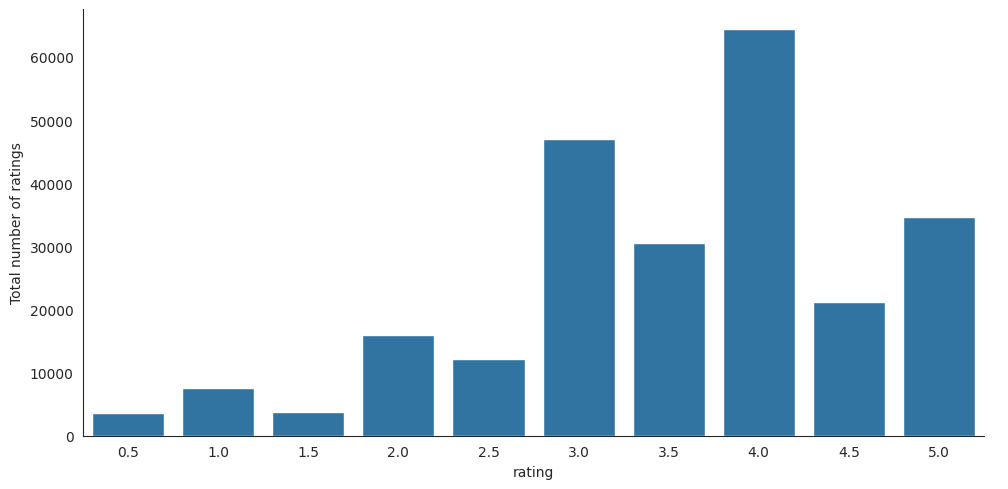

In [83]:
with sns.axes_style('white'):
    g = sns.catplot(data=df_train, x="rating", y=None, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(df_train["rating"])}')

In [84]:
df_trainv1 = pd.merge(df_train, df_movies, on='movieId')

df_trainv2 = df_trainv1[['userId', 'movieId',	'title','rating',	'timestamp']]

df_trainv2.head()

df_trainv2.to_csv('df_trainv2.csv', index=False)

In [85]:
merged_df = pd.merge(df_movies, df_imdb_data, on='movieId')

final_df = merged_df[['movieId', 'title', 'title_cast', 'genres', 'director', 'runtime', 'budget',	'plot_keywords']]

final_df.head()

final_df.to_csv('final_df.csv', index=False)

In [86]:
final_df['director_titlecast'] = (pd.Series(final_df[['director', 'title_cast']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

titles = final_df['title']
indices = pd.Series(final_df.index, index=final_df['title'])

In [87]:
indices.head()

title
Toy Story (1995)                      0
Jumanji (1995)                        1
Grumpier Old Men (1995)               2
Waiting to Exhale (1995)              3
Father of the Bride Part II (1995)    4
dtype: int64

In [88]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2),
                     min_df=0, stop_words='english')

# Produce a feature matrix, where each row corresponds to a book,
# with TF-IDF features as columns
tf_movietags_matrix = tf.fit_transform(final_df['director_titlecast'])

In [89]:
cosine_sim_movietags = cosine_similarity(tf_movietags_matrix,
                                        tf_movietags_matrix)
print (cosine_sim_movietags.shape)

(24866, 24866)


In [90]:
cosine_sim_movietags[:5]

array([[1.        , 0.        , 0.00481673, ..., 0.00606498, 0.00317293,
        0.01385015],
       [0.        , 1.        , 0.00251314, ..., 0.        , 0.        ,
        0.        ],
       [0.00481673, 0.00251314, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01596706, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00451436, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [92]:
def content_generate_top_N_recommendations(movie_title, N=10):
    # Convert the string book title to a numeric index for our
    # similarity matrix
    b_idx = indices[movie_title]
    # Extract all similarity values computed with the reference book title
    sim_scores = list(enumerate(cosine_sim_movietags[b_idx]))
    # Sort the values, keeping a copy of the original index of each value
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Select the top-N values for recommendation
    sim_scores = sim_scores[1:N]
    # Collect indexes
    book_indices = [i[0] for i in sim_scores]
    # Convert the indexes back into titles
    return titles.iloc[book_indices]

In [93]:
content_generate_top_N_recommendations("Toy Story (1995)", N=10)

3020                                    Toy Story 2 (1999)
14758                                   Toy Story 3 (2010)
23079              Toy Story Toons: Partysaurus Rex (2012)
22140                    Toy Story Toons: Small Fry (2011)
22139            Toy Story Toons: Hawaiian Vacation (2011)
20294                           Toy Story of Terror (2013)
23081                    Toy Story That Time Forgot (2014)
10314    After School Special (a.k.a. Barely Legal) (2003)
20452                                 Tim's Vermeer (2013)
Name: title, dtype: object

In [94]:
content_generate_top_N_recommendations("Jumanji (1995)", N=10)

23134    Robin Williams: Weapons of Self Destruction (2...
3413                                   Return to Me (2000)
4680                                Little Man Tate (1991)
19327                             Unspeakable Acts (1990) 
2016     Halloween H20: 20 Years Later (Halloween 7: Th...
4062                                     15 Minutes (2001)
4969                   Adventures of Huck Finn, The (1993)
1575                                 Ice Storm, The (1997)
630                                      Diabolique (1996)
Name: title, dtype: object

In [95]:
content_generate_top_N_recommendations("Father of the Bride Part II (1995)", N=10)

6818            Father of the Bride (1991)
19824                  Scenic Route (2013)
1493               War at Home, The (1996)
5857                        My Girl (1991)
9889     Jiminy Glick in La La Wood (2004)
6099        Bringing Down the House (2003)
1699                   Mass Transit (1998)
11244               We Are Marshall (2006)
10647             Failure to Launch (2006)
Name: title, dtype: object

In [96]:
def content_generate_rating_estimate(movie_title, user, rating_data, k=20, threshold=0.0):
    # Convert the book title to a numeric index for our
    # similarity matrix
    b_idx = indices[movie_title]
    neighbors = [] # <-- Stores our collection of similarity values

    # Gather the similarity ratings between each book the user has rated
    # and the reference book
    for index, row in rating_data[rating_data['userId']==user].iterrows():
        sim = cosine_sim_movietags[b_idx-1, indices[row['title']]-1]
        neighbors.append((sim, row['rating']))
    # Select the top-N values from our collection
    k_neighbors = heapq.nlargest(k, neighbors, key=lambda t: t[0])

    # Compute the weighted average using similarity scores and
    # user item ratings.
    simTotal, weightedSum = 0, 0
    for (simScore, rating) in k_neighbors:
        # Ensure that similarity ratings are above a given threshold
        if (simScore > threshold):
            simTotal += simScore
            weightedSum += simScore * rating
    try:
        predictedRating = weightedSum / simTotal
    except ZeroDivisionError:
        # Cold-start problem - No ratings given by user.
        # We use the average rating for the reference item as a proxy in this case
        predictedRating = np.mean(rating_data[rating_data['title']==movie_title]['rating'])
    return predictedRating

In [97]:
df_trainv2.head()

,userId,movieId,title,rating,timestamp
0,5163,57669,In Bruges (2008),4.0,1.518350e+09
1,87388,57669,In Bruges (2008),3.5,1.237455e+09
2,137050,57669,In Bruges (2008),4.0,1.425632e+09
3,120490,57669,In Bruges (2008),4.5,1.408229e+09
4,50616,57669,In Bruges (2008),4.5,1.446942e+09


In [103]:
df_trainv2[df_trainv2['userId'] == 5163][3:10]

,userId,movieId,title,rating,timestamp


In [99]:
title = "Heat (1995)"
actual_rating = df_trainv2[(df_trainv2['userId'] == 50616) & (df_trainv2['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(movie_title=title, user=50616, rating_data=df_trainv2)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

KeyError: 'Nocturnal Animals'

In [63]:
title = "Matrix, The (1999)"
actual_rating = df_trainv2[(df_trainv2['userId'] == 87388) & (df_trainv2['title'] == title)]['rating'].values[0]
pred_rating = content_generate_rating_estimate(movie_title=title, user=87388, rating_data=df_trainv2)
print (f"Title - {title}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {pred_rating}")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
from surprise import Dataset, Reader

from surprise.model_selection import train_test_split

from surprise import SVD

from surprise import accuracy

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_trainv2[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

model = SVD()
model.fit(trainset)

predictions = model.test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.8061
1.8060726271798841


In [ ]:
df_test2 = pd.read_csv('test.csv')

test_pred = []

for row in df_test2.itertuples():
  userID = row.userId
  movieId = row.movieId
  prediction = model.predict(userID, movieId).est
  test_pred.append({'Id': f"{userID}_{movieId}", 'rating': prediction})

sub_df = pd.DataFrame(test_pred)

sub_df.to_csv('sub4.csv', index=False, float_format='%.1f')

In [36]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      1 non-null      object 
 1   rating  1 non-null      float64
dtypes: float64(1), object(1)
memory usage: 144.0+ bytes
